In [27]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import lightgbm as lgbm

from sklearn.neural_network import MLPClassifier

In [7]:
#%cd ./network_sniff/
#%ls

# 0) Create reporting 

In [8]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [9]:
df_mining = pd.read_csv("./network_sniff/traffic_minage_1811_15.csv", index_col= 0)
df_not_mining = pd.read_csv("./network_sniff/2911_traffic_calme.csv", index_col= 0)

In [10]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining

In [11]:
df_mining['miner'] = True
df_not_mining['miner'] = False

Compute time difference between two packages

In [12]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

In [13]:
df_ML = pd.concat([df_mining, df_not_mining])
df_ML.reset_index(inplace = True)
df_ML.drop(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)

In [14]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'delta'], dtype='object')

In [15]:
df_ML.groupby('miner').mean()

,Length,delta
miner,,
False,755.159375,0.030100
True,89.083333,0.726751


array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>]], dtype=object)

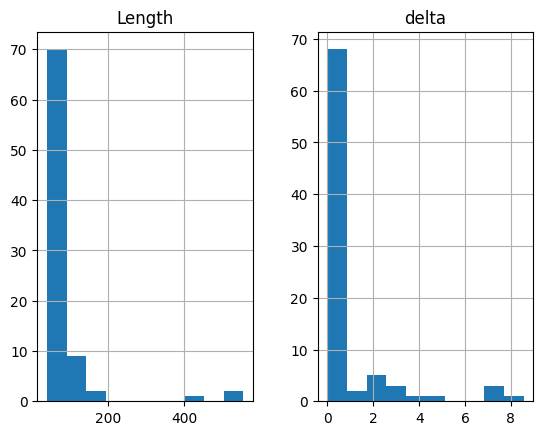

In [16]:
df_ML.loc[df_ML['miner'] == True].hist()

array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>]], dtype=object)

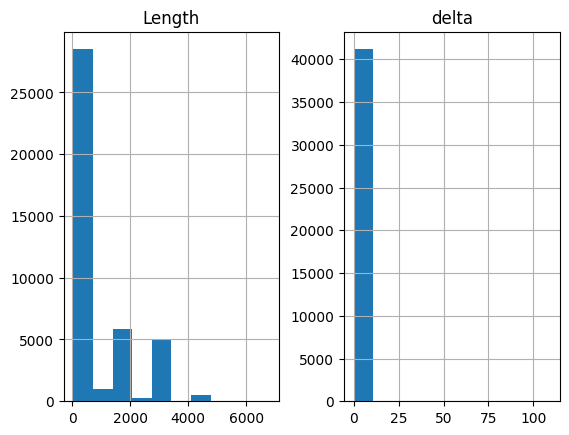

In [17]:
df_ML.loc[df_ML['miner'] == False].hist()

In [18]:
y = df_ML['miner']
x = df_ML.drop('miner', axis = 1)

In [19]:
y.describe

<bound method NDFrame.describe of 1         True
2         True
3         True
4         True
5         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41270, dtype: bool>

In [20]:
y.value_counts()

False    41186
True        84
Name: miner, dtype: int64

# ML Algorithm

In [25]:
#Setting model
model = svm.SVC(kernel="rbf", gamma="scale", class_weight='balanced')

In [26]:
model_cv_rapport(model, "Non tuned SVC", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................[CV] START .....................................................................

[CV] START .....................................................................
[CV] END  accuracy: (test=0.453) f1: (test=0.006) precision: (test=0.003) recall: (test=0.765) roc_auc: (test=0.683) total time=  23.8s
[CV] END  accuracy: (test=0.366) f1: (test=0.006) precision: (test=0.003) recall: (test=0.938) roc_auc: (test=0.690) total time=  27.5s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.0s remaining:   42.0s


[CV] END  accuracy: (test=0.370) f1: (test=0.006) precision: (test=0.003) recall: (test=1.000) roc_auc: (test=0.826) total time=  28.4s
[CV] END  accuracy: (test=0.514) f1: (test=0.008) precision: (test=0.004) recall: (test=0.941) roc_auc: (test=0.807) total time=  28.5s
[CV] END  accuracy: (test=0.440) f1: (test=0.007) precision: (test=0.003) recall: (test=0.941) roc_auc: (test=0.842) total time=  28.5s
Non tuned SVC --------------------------------------
Precision:  0.00328183
Recall:  0.91691176
F1:  0.00653994
ROC:  0.76969121
Accuracy:  0.42842258


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   28.9s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished


In [40]:
# Set Neuoral Network Model
model_nn = MLPClassifier(hidden_layer_sizes=(100,100),activation='relu', solver='sgd', random_state=1, max_iter=20, batch_size='auto', verbose=True)

In [41]:
model_cv_rapport(model_nn, "Neuoral Network Classfication", x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
Iteration 1, loss = 0.31142887
Iteration 1, loss = 0.31121727
Iteration 1, loss = 0.31134514
Iteration 1, loss = 0.31132045
Iteration 1, loss = 0.31117132
Iteration 2, loss = 0.07062517
Iteration 2, loss = 0.07035629
Iteration 2, loss = 0.07193491
Iteration 2, loss = 0.07059260
Iteration 2, loss = 0.07055440
Iteration 3, loss = 0.03526578
Iteration 3, loss = 0.03710670
Iteration 3, loss = 0.03541266
Iteration 3, loss = 0.03541394
Iteration 3, loss = 0.03544504
Iteration 4, loss = 0.02715530
Iteration 4, loss = 0.02536380
Iteration 4, loss = 0.02549740
Iteration 4, loss = 0.02550652
Iterat

/home/augustin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/augustin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter

Iteration 20, loss = 0.01400750
Iteration 20, loss = 0.01478547
[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.510) total time=   5.5s
Iteration 20, loss = 0.01480570
[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.556) total time=   5.5s
[CV] END  accuracy: (test=0.998) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.480) total time=   5.5s
Neuoral Network Classfication --------------------------------------
Precision:  0.0
Recall:  0.0
F1:  0.0
ROC:  0.52324146
Accuracy:  0.99796462


/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
